Importamos las liberías que vamos a usar:

In [29]:
import numpy as np
import threading
import time
import os
import yaml
import threading
from datetime import datetime
import matplotlib.pyplot as plt

Importamos la clase de nuestro instrumento de medición, la Red Pitaya:

In [3]:
from Model.RP import RP

Definimos nuestra clase Experiment donde vamos a tener todos los métodos necesarios para realizar las mediciones usando la Red Pitaya y donde importamos los parámetros de nuestra medición desde un archivo de configuración .yml:

In [4]:
class Experiment:
    def __init__(self, config_file):
        self.config_file = config_file
        self.scan_data = [[0],[0]]
        self.is_running = False
        self.config_loaded = False
        self.RP_loaded = False
        
    def load_config(self):
        with open(self.config_file, 'r') as f:
            self.config = yaml.load(f, Loader=yaml.FullLoader)
            
        if self.config['RP']['IP'] is None:
            raise Exception('IP no ingresada')
        if self.config['Scan']['DF'] is None:
            raise Exception('Decimation factor no ingresado')
        if self.config['Scan']['T_source'] is None:
            raise Exception('Fuente del trigger no ingresada')
        if self.config['Scan']['T_level'] is None:
            raise Exception('Nivel del trigger no ingresado')
        if self.config['Scan']['T_delay'] is None:
            raise Exception('Delay del trigger no ingresado')
        if self.config['Scan']['M_source'] is None:
            raise Exception('Canal de medición no ingresado')
        if self.config['Scan']['N_sample'] is None:
            raise Exception('Número de puntos no ingresado')
        if self.config['Saving']['filename'] is None:
            raise Exception('Nombre del archivo de guardado no ingresado')
        if self.config['Saving']['folder'] is None:
            raise Exception('Carpeta de destino de los datos guardados no ingresada')
        if not np.log2(self.config['Scan']['DF']).is_integer():
            raise Exception('El decimation factor elegido no es potencia de 2')
        if self.config['Scan']['DF']>65536:
            raise Exception('El decimation factor elegido es mayor a 65536')
        if self.config['Scan']['T_level']>1.0:
            raise Exception('El nivel del trigger debe ser menor a 1V')
        if not  any(x in self.config['Scan']['T_source'] for x in ['DISABLED', 'NOW', 'CH1_PE', 'CH1_NE', 'CH2_PE', 'CH2_NE', 'EXT_PE', 'EXT_NE', 'AWG_PE', 'AWG_NE']) :
            raise Exception('Fuente del trigger no válida')
        if not  any(x in self.config['Scan']['M_source'] for x in ['SOUR1', 'SOUR2']) :
            raise Exception('Canal de adquisición no válido')
        if self.config['Scan']['N_sample']>8192:
            raise Exception('Número de puntos mayor a 8192')
        
        self.config_loaded = True
    
    def load_RP(self):
        if self.config_loaded:
            self.RP = RP(self.config['RP']['IP'])
            self.RP_loaded = True
        else:
            raise Exception('Archivo de configuración no cargado')
            
    def do_scan(self):
        if self.is_running:
            #print('Scan already running')
            return
        if not self.RP_loaded:
            raise Exception('Red Pitaya no cargada')
        self.keep_running = True
        self.is_running = True
        self.RP.set_DF(self.config['Scan']['DF'])
        self.RP.set_trigger(self.config['Scan']['T_source'], self.config['Scan']['T_level'], self.config['Scan']['T_delay'])
        self.RP.measure(self.config['Scan']['M_source'], self.config['Scan']['N_sample'])
        self.scan_data[0] = self.RP.x
        self.scan_data[1] = self.RP.data
        self.is_running = False
        if not self.keep_running:
            return
        
    def start_scan(self):
        self.scan_thread = threading.Thread(target=self.do_scan)
        self.scan_thread.start()
        
    def stop_scan(self):
        self.keep_running = False
        
    def save_data(self):
        data_folder = self.config['Saving']['folder']
        today_folder = f'{datetime.today():%Y-%m-%d}'
        saving_folder = os.path.join(data_folder, today_folder)
        if not os.path.isdir(saving_folder):
            os.makedirs(saving_folder)
        
        data = np.vstack([self.scan_data[0],self.scan_data[1]]).T
        header = 'Tiempo [s], Voltaje [V]'
        
        filename = self.config['Saving']['filename']
        base_name = filename.split('.')[0]
        ext = filename.split('.')[-1]
        i = 1
        while os.path.isfile(os.path.join(saving_folder, f'{base_name}_{i:04d}.{ext}')):
            i += 1
        data_file = os.path.join(saving_folder, f'{base_name}_{i:04d}.{ext}')
        metadata_file = os.path.join(saving_folder, f'{base_name}_{i:04d}_metadata.yml')
        
        np.savetxt(data_file, data, header=header)
        with open(metadata_file, 'w') as f:
            f.write(yaml.dump(self.config, default_flow_style=False))
    
    def finalize(self):
        self.RP.finalize()

A continuación creamos una instancia de la clase Experiment e iniciamos la comunicación con la Red Pitaya seteando los parámetros de adquisición:

In [12]:
exp=Experiment('experiment.yml')
exp.load_config()
exp.load_RP()
print(exp.RP)

Red Pitaya (Model: STEMlab 125-14 v1.0)


Realizamos una serie de mediciones usando la Red Pitaya y graficamos cada una:

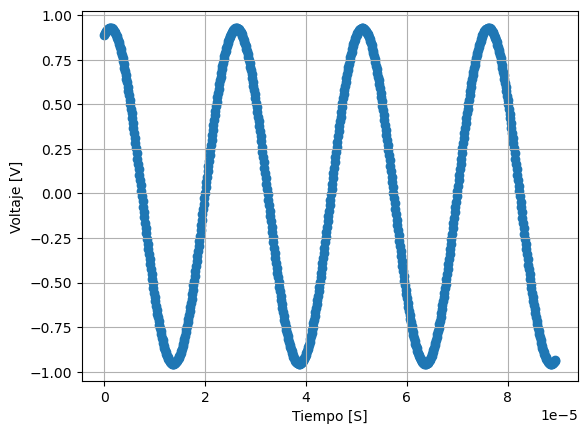

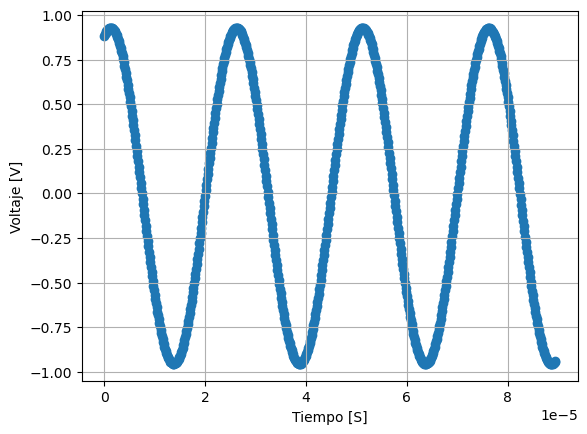

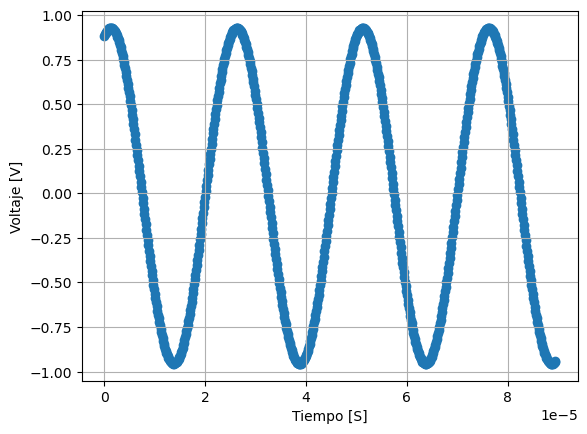

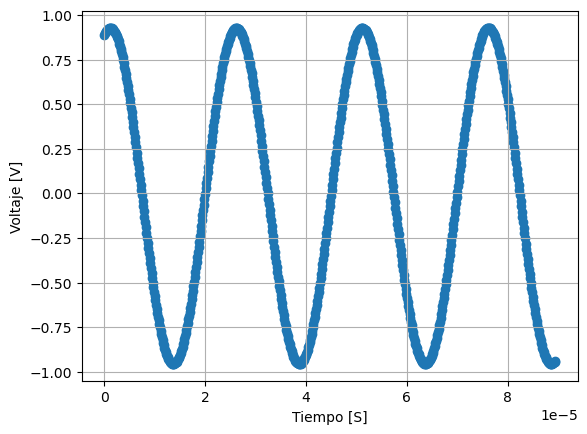

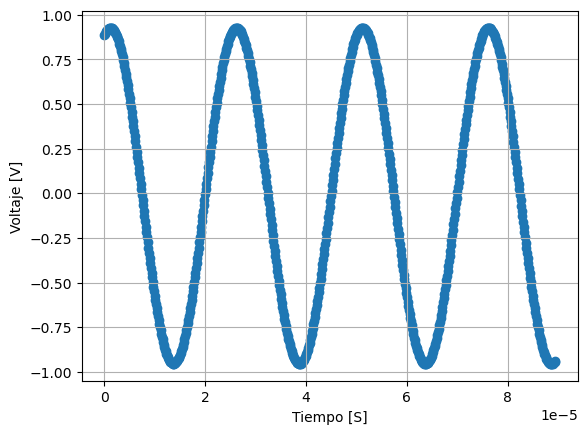

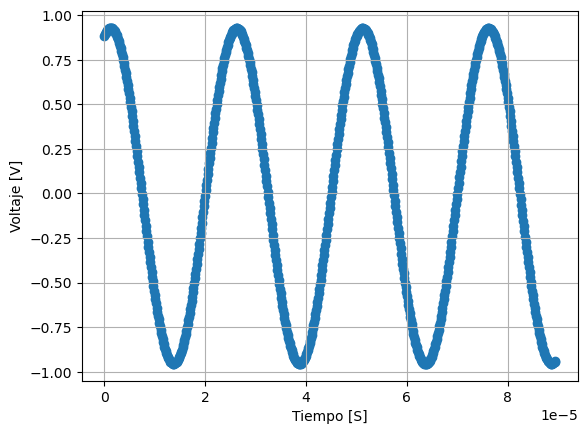

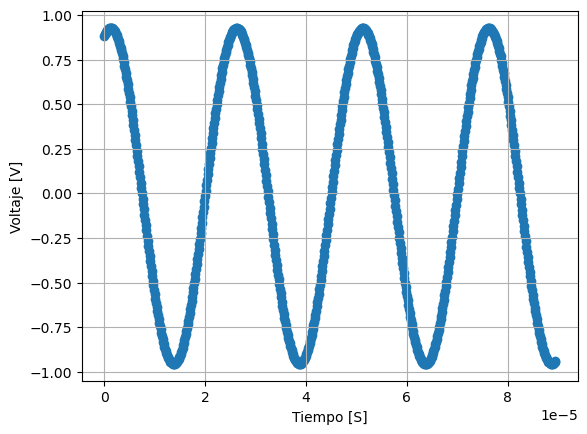

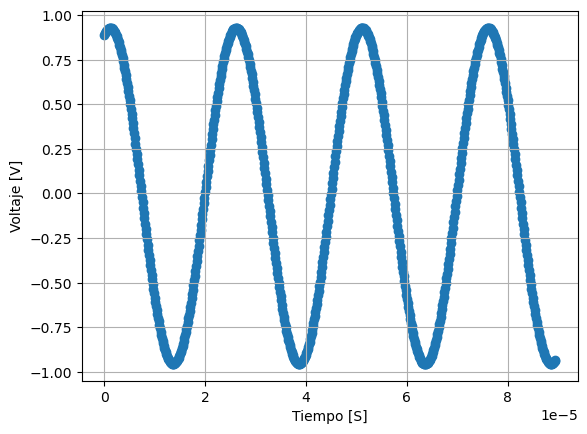

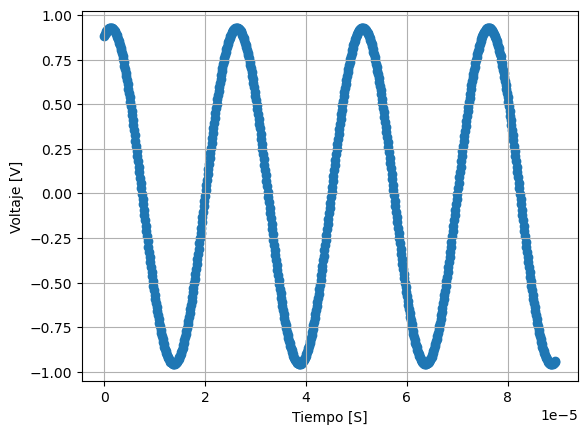

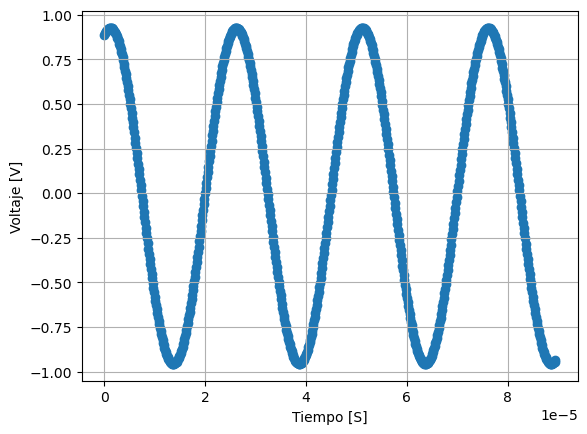

In [38]:
N=10 #Número de meidicones a realizar
y=[[]]*N
x=[[]]*N

for i in range(N):
    exp.do_scan()
    x[i]=exp.scan_data[0]
    y[i]=exp.scan_data[1]
    plt.figure()
    plt.xlabel('Tiempo [S]')
    plt.ylabel('Voltaje [V]')
    plt.grid()
    plt.scatter(x[i],y[i])
    plt.show()
    


Con las mediciones que tomamos calculamos el promedio y el desvío estándar:

In [42]:
y_mean=[]
y_std=[]

for i in range(N):
    y_mean.append(np.mean(y[i]))

for i in range(N):
    y_std.append(np.std(y[i]))

mean=np.mean(y_mean)
std=np.std(y_std)

print(f'Lista de promedios en cada serie de y: {y_mean}')
print(f'Promedio de los promomedios de las series de y: {mean}')
print(f'Lista de desviaciones estándar en cada serie de y: {y_std}')
print(f'Desviación estándar de las desviaciones estándar de las series de y: {std}')

Lista de promedios en cada serie de y: [-0.00942660428571429, -0.007857139999999992, -0.007422581428571447, -0.008886210000000016, -0.008439260000000018, -0.007965792857142863, -0.008262069999999996, -0.009337857142857137, -0.00792307571428571, -0.0096690042857143]
Promedio de los promomedios de las series de y: -0.008518959571428578
Lista de desviaciones estándar en cada serie de y: [0.6732727022463307, 0.6731990779373347, 0.6731806207369082, 0.6733564436388991, 0.673239745100356, 0.6731359316189168, 0.6733200175481913, 0.6733320458526596, 0.673282266536617, 0.6733420618765186]
Desviación estándar de las desviaciones estándar de las series de y: 7.136535051334082e-05
